In [8]:
# بخش 1 - Imports & Config
import os, json, joblib, warnings, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# مدل‌های Boosted (در صورت تمایل بعداً فعال کن)
try:
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

RANDOM_STATE = 42
TEST_SIZE = 0.2
USE_SMOTE = True   # اگر سیستم ضعیف‌تره، False کن
DATA_PATH = "creditcard.csv"  # یا مسیر کامل
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)


In [9]:
# بخش 2 - Load data
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "فایل creditcard.csv را از Kaggle دانلود و کنار نوت‌بوک قرار بده."
    )

df = pd.read_csv(DATA_PATH)
assert "Class" in df.columns, "ستون هدف 'Class' وجود ندارد."

print("Shape:", df.shape)
display(df.head(3))

class_counts = df["Class"].value_counts()
print("\nClass distribution:\n", class_counts)
print("\nPercent fraud: {:.6f}%".format(100 * df["Class"].mean()))


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0



Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Percent fraud: 0.172749%


In [10]:
# بخش 3 - Preprocessing helpers
scaler = StandardScaler()

def preprocess_fit_transform(df_):
    X = df_.drop(columns=["Class"])
    y = df_["Class"].astype(int)
    if not {"Amount", "Time"}.issubset(X.columns):
        raise ValueError("ستون‌های Amount و Time باید موجود باشند.")
    X_scaled = X.copy()
    X_scaled[["scaled_amount","scaled_time"]] = scaler.fit_transform(X[["Amount","Time"]])
    X_scaled = X_scaled.drop(columns=["Amount","Time"])
    return X_scaled, y

def preprocess_transform(df_like_train):
    X = df_like_train.copy()
    X_scaled = X.copy()
    X_scaled[["scaled_amount","scaled_time"]] = scaler.transform(X[["Amount","Time"]])
    X_scaled = X_scaled.drop(columns=["Amount","Time"])
    return X_scaled


In [11]:
# بخش 4 - Split
X_full = df.drop(columns=["Class"])
y_full = df["Class"].astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_full, y_full, test_size=TEST_SIZE, stratify=y_full, random_state=RANDOM_STATE
)

# Fit scaler فقط روی train
_ = scaler.fit(X_train_raw[["Amount","Time"]])
X_train = preprocess_transform(X_train_raw)
X_test  = preprocess_transform(X_test_raw)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (227845, 30) | Test: (56962, 30)


In [12]:
# بخش 5 - Optional SMOTE
if USE_SMOTE:
    smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.1)  # حدود 10% منفی‌ها
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    print("After SMOTE:", X_train_sm.shape)
    print(pd.Series(y_train_sm).value_counts())
else:
    X_train_sm, y_train_sm = X_train, y_train


After SMOTE: (250196, 30)
Class
0    227451
1     22745
Name: count, dtype: int64


In [13]:
# بخش 6 - Build models
models = {
    "logreg": LogisticRegression(
        max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE, verbose=1
    ),
    "rf": RandomForestClassifier(
        n_estimators=400, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
    )
}

# اگر دوست داری بعداً فعال کنی:
USE_GRADIENT_BOOSTED = False
if HAS_XGB and USE_GRADIENT_BOOSTED:
    models["xgb"] = XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        tree_method="hist", eval_metric="logloss",
        n_jobs=-1, random_state=RANDOM_STATE, verbosity=1
    )
if HAS_XGB and USE_GRADIENT_BOOSTED:
    models["lgbm"] = LGBMClassifier(
        n_estimators=800, num_leaves=64, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
    )

list(models.keys())


['logreg', 'rf']

In [18]:
# بخش 7 - Train & evaluate (نسخهٔ تمیز با لاگ و زمان‌سنج)
import time
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def ascii_bar(x, width=20):
    """نمایش میله متنی برای زیبایی خلاصه‌ها (0..1)"""
    x = float(np.clip(x, 0, 1))
    filled = int(round(x * width))
    return "█" * filled + "·" * (width - filled)

summary = {}
per_model_details = {}  # برای نمودارها و تحلیل‌های بعدی

print("🚀 شروع آموزش مدل‌ها...\n")

for name, model in models.items():
    print(f"\n=== [{name.upper()}] ===")

    # آموزش با پیشرفت متنی برای RF (ساخت تدریجی درخت‌ها)
    start = time.time()
    if isinstance(model, RandomForestClassifier):
        total = model.n_estimators
        rf = RandomForestClassifier(
            n_estimators=1,
            class_weight=model.class_weight,
            n_jobs=model.n_jobs,
            random_state=model.random_state,
            warm_start=True,
            max_depth=model.max_depth,
            max_features=model.max_features
        )
        rf.fit(X_train_sm, y_train_sm)
        # افزایش تدریجی تعداد درخت‌ها
        step = max(1, total // 20)
        for i in range(2, total + 1):
            rf.n_estimators = i
            rf.fit(X_train_sm, y_train_sm)
            if i % step == 0 or i == total:
                pct = i / total
                print(f"\rBuilding trees [{ascii_bar(pct)}] {pct:>6.1%}", end="")
        print()
        fitted_model = rf
    else:
        print("Fitting model ...")
        model.fit(X_train_sm, y_train_sm)
        fitted_model = model

    elapsed = time.time() - start

    # ارزیابی روی تست
    y_prob = fitted_model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_prob)
    pr  = average_precision_score(y_test, y_prob)

    # برای رسم ROC/PR بعداً
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prec, rec, thr = precision_recall_curve(y_test, y_prob)

    # ذخیره
    summary[name] = {"roc_auc": float(roc), "pr_auc": float(pr), "train_time_sec": round(elapsed, 2)}
    per_model_details[name] = {
        "model": fitted_model,
        "y_prob": y_prob,
        "fpr": fpr, "tpr": tpr,
        "prec": prec, "rec": rec, "thr": thr
    }

    # خروجی کنسولی شسته‌رفته
    print(f"⏱️ Train time: {elapsed:.2f}s")
    print(f"✅ TEST → ROC AUC: {roc:.4f} | PR AUC: {pr:.4f}")
    print(f"ROC  [{ascii_bar(roc)}]  PR [{ascii_bar(pr)}]")

# جدول خلاصه
df_summary = pd.DataFrame(summary).T.sort_values("pr_auc", ascending=False)
display(df_summary)


🚀 شروع آموزش مدل‌ها...


=== [LOGREG] ===
Fitting model ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


⏱️ Train time: 1.80s
✅ TEST → ROC AUC: 0.9688 | PR AUC: 0.7257
ROC  [███████████████████·]  PR [███████████████·····]

=== [RF] ===
Building trees [████████████████████] 100.0%
⏱️ Train time: 681.17s
✅ TEST → ROC AUC: 0.9778 | PR AUC: 0.8670
ROC  [████████████████████]  PR [█████████████████···]


,roc_auc,pr_auc,train_time_sec
rf,0.977832,0.866966,681.17
logreg,0.968837,0.725685,1.80


In [19]:
# بخش 8 - Threshold selection + Reports
from sklearn.metrics import classification_report, confusion_matrix

def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    thr = np.r_[0.0, thr]
    best = {"t": 0.5, "f1": -1, "p": 0.0, "r": 0.0}
    for p, r, t in zip(prec, rec, thr):
        f1 = 0 if (p + r) == 0 else 2 * p * r / (p + r)
        if f1 > best["f1"]:
            best = {"t": float(t), "f1": float(f1), "p": float(p), "r": float(r)}
    return best

thresholds = {}
reports = {}
cmaps = {}

for name, det in per_model_details.items():
    y_prob = det["y_prob"]
    best = best_threshold_by_f1(y_test, y_prob)
    t = best["t"]
    y_pred = (y_prob >= t).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    rep = classification_report(y_test, y_pred, output_dict=True)

    thresholds[name] = best
    reports[name] = rep
    cmaps[name] = cm

    # خروجی کنسولی
    print(f"\n{name.upper()} — Best threshold for F1 = {t:.4f}")
    print(f"F1={best['f1']:.4f} | Precision={best['p']:.4f} | Recall={best['r']:.4f}")
    print("Confusion Matrix:")
    print(cm)

# نمایش یک جدول خلاصه آستانه‌ها
df_thr = pd.DataFrame(thresholds).T.rename(columns={"t":"threshold","p":"precision","r":"recall"})
display(df_thr)



LOGREG — Best threshold for F1 = 1.0000
F1=0.8247 | Precision=0.8333 | Recall=0.8163
Confusion Matrix:
[[56847    17]
 [   18    80]]

RF — Best threshold for F1 = 0.7000
F1=0.8588 | Precision=0.9620 | Recall=0.7755
Confusion Matrix:
[[56860     4]
 [   22    76]]


,threshold,f1,precision,recall
logreg,1.0,0.824742,0.833333,0.816327
rf,0.7,0.858757,0.962025,0.775510


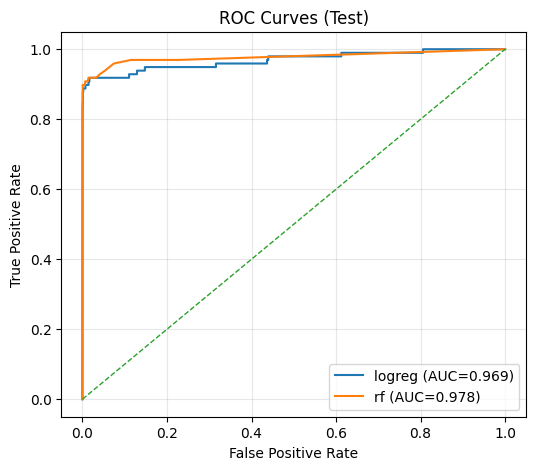

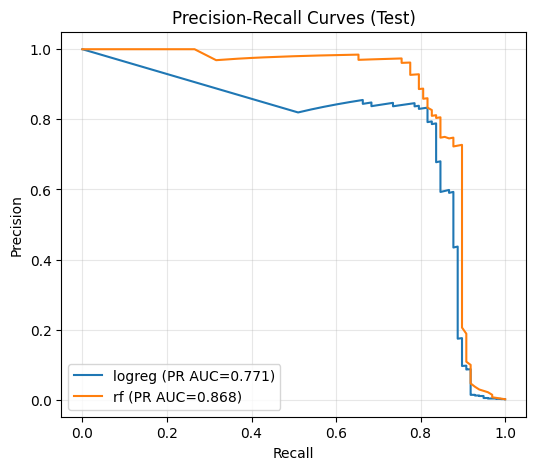

In [20]:
# بخش 9 - ROC & PR curves
plt.figure(figsize=(6,5))
for name, det in per_model_details.items():
    fpr, tpr = det["fpr"], det["tpr"]
    roc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_val:.3f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6,5))
for name, det in per_model_details.items():
    prec, rec = det["prec"], det["rec"]
    pr_val = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} (PR AUC={pr_val:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


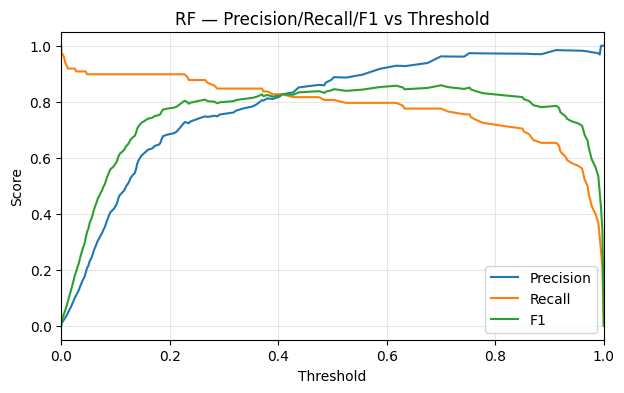

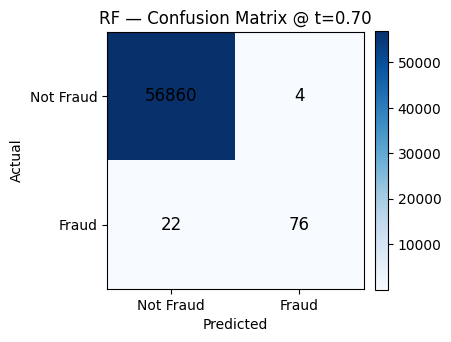

Classification Report (best model @ best threshold):

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9500    0.7755    0.8539        98

    accuracy                         0.9995     56962
   macro avg     0.9748    0.8877    0.9269     56962
weighted avg     0.9995    0.9995    0.9995     56962



In [21]:
# بخش 10 - Deep dive روی بهترین مدل بر اساس PR AUC
import itertools

best_name = df_summary.index[0]  # بالاترین PR AUC
det = per_model_details[best_name]
y_prob = det["y_prob"]

# منحنی‌های P-R-F1 در برابر آستانه
prec, rec, thr = precision_recall_curve(y_test, y_prob)
thr = np.r_[0.0, thr]
f1s = []
for p, r in zip(prec, rec):
    f1s.append(0 if (p+r)==0 else 2*p*r/(p+r))
f1s = np.array(f1s)

plt.figure(figsize=(7,4))
plt.plot(thr, prec, label="Precision")
plt.plot(thr, rec,  label="Recall")
plt.plot(thr, f1s,  label="F1")
plt.xlim(0, 1)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(f"{best_name.upper()} — Precision/Recall/F1 vs Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ماتریس اشتباهاتِ بهترین مدل در آستانهٔ بهینه
best_t = thresholds[best_name]["t"]
y_pred_best = (y_prob >= best_t).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
rep = classification_report(y_test, y_pred_best, digits=4)

# Heatmap ساده با matplotlib (بدون seaborn)
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_title(f"{best_name.upper()} — Confusion Matrix @ t={best_t:.2f}")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Not Fraud","Fraud"])
ax.set_yticklabels(["Not Fraud","Fraud"])

# اعداد داخل خانه‌ها
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

print("Classification Report (best model @ best threshold):\n")
print(rep)


In [22]:
# بخش 11 - Save artifacts
best_name = df_summary.index[0]
best_model_fitted = per_model_details[best_name]["model"]

joblib.dump(best_model_fitted, os.path.join(MODELS_DIR, f"{best_name}_model.pkl"))
joblib.dump(best_model_fitted, os.path.join(MODELS_DIR, "best_model.pkl"))
joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler.pkl"))

with open(os.path.join(MODELS_DIR, "metrics_summary.json"), "w", encoding="utf-8") as f:
    json.dump(
        {
            "summary": summary,
            "thresholds": thresholds,
            "best_model": best_name
        },
        f, ensure_ascii=False, indent=2
    )

print(f"✅ Saved artifacts in `{MODELS_DIR}/` | Best model = {best_name}")


✅ Saved artifacts in `models/` | Best model = rf
